# Task: Store specific Demand forecast of sales.

# 1: IMPORT REQUIRED LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import warnings

warnings.simplefilter(action='ignore')

# 2: CONFIGURATION

In [2]:
FILE_PATH = r'D:\Slooze Dataset\slooze_challenge\SalesFINAL12312016.csv'
STORES = sorted([1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24,
                 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4,
                 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 52, 53, 54, 55,
                 56, 57, 58, 59, 6, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 7, 70,
                 71, 72, 73, 74, 75, 76, 77, 78, 79, 8, 9])
XGB_N_ESTIMATORS = [50, 70, 100, 120, 150, 170, 200]
XGB_MAX_DEPTHS = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
FORECAST_DAYS = 2

# 3: LOAD AND PREPROCESS DATA

In [3]:
def load_and_preprocess_data(file_path):
    """
    Loads CSV data, converts SalesDate to datetime, and aggregates SalesQuantity by Store and Date.
    """
    try:
        df_raw = pd.read_csv(file_path)
        df_raw['SalesDate'] = pd.to_datetime(df_raw['SalesDate'])
        
        # Aggregate sales per day per store
        df_ts = df_raw.groupby(['Store', 'SalesDate'])['SalesQuantity'].sum().reset_index()
        df_ts = df_ts.rename(columns={'SalesQuantity': 'y'})
        
        print(f"✅ Successfully loaded and aggregated data. Total daily entries: {len(df_ts)}")
        return df_ts
    
    except FileNotFoundError:
        print(f"❌ File not found at `{file_path}`")
        return pd.DataFrame()
    
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return pd.DataFrame()

# Load the data
full_df = load_and_preprocess_data(FILE_PATH)

# Display sample data
full_df.head()


✅ Successfully loaded and aggregated data. Total daily entries: 2759


,Store,SalesDate,y
0,1,2016-01-01,380
1,1,2016-01-02,1543
2,1,2016-01-03,848
3,1,2016-01-04,596
4,1,2016-01-05,1046


# 4: CREATE XGBOOST FEATURES

In [4]:
def create_xgb_features(df):
    """
    Adds time-based features for XGBoost model.
    """
    df['dayofweek'] = df['SalesDate'].dt.dayofweek
    df['dayofyear'] = df['SalesDate'].dt.dayofyear
    df['day'] = df['SalesDate'].dt.day
    df['month'] = df['SalesDate'].dt.month
    df['year'] = df['SalesDate'].dt.year
    df['weekofyear'] = df['SalesDate'].dt.isocalendar().week.astype(int)
    return df

# 5: METRIC CALCULATION FUNCTION

In [5]:
def calculate_metrics(y_true, y_pred):
    """
    Calculates MAE and RMSE.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse


# 6: XGBOOST MODEL TRAINING & FORECAST

In [6]:
def run_xgb_tuning_and_forecast(store_data, n_estimators_list, max_depth_list, forecast_days):
    """
    Trains XGBoost with hyperparameter tuning on last 7 days as validation,
    then forecasts future demand.
    """
    store_data_features = create_xgb_features(store_data.copy())

    VAL_SIZE = 7
    if len(store_data_features) < VAL_SIZE + 1:
        return None, "Not enough data.", 0, 0, None, None

    # Split train and validation
    train_df = store_data_features.iloc[:-VAL_SIZE]
    val_df = store_data_features.iloc[-VAL_SIZE:]

    FEATURES = ['dayofweek', 'dayofyear', 'day', 'month', 'year', 'weekofyear']
    TARGET = 'y'

    X_train, y_train = train_df[FEATURES], train_df[TARGET]
    X_val, y_val = val_df[FEATURES], val_df[TARGET]

    best_mae = float('inf')
    best_params = {}
    best_model = None

    print(f"🔍 Tuning XGBoost Model for Store {store_data['Store'].iloc[0]}...")

    for n_est in n_estimators_list:
        for m_depth in max_depth_list:
            model = xgb.XGBRegressor(
                n_estimators=n_est,
                max_depth=m_depth,
                random_state=42,
                objective='reg:absoluteerror',
                tree_method='hist'
            )
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_train, y_train)
            
            val_pred = model.predict(X_val)
            current_mae, _ = calculate_metrics(y_val.values, val_pred)

            if current_mae < best_mae:
                best_mae = current_mae
                best_params = {'n_estimators': n_est, 'max_depth': m_depth}
                best_model = model

    # Evaluate on validation
    val_pred_best = best_model.predict(X_val)
    mae, rmse = calculate_metrics(y_val.values, val_pred_best)

    # Future forecast
    last_date = store_data['SalesDate'].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days)
    future_df = pd.DataFrame({'SalesDate': future_dates})
    future_df = create_xgb_features(future_df)

    xgb_forecast = best_model.predict(future_df[FEATURES])
    xgb_forecast_df = pd.DataFrame({
        'Date': future_dates,
        'Forecast': np.maximum(0, xgb_forecast.round(0)).astype(int)
    })

    val_df['Prediction'] = np.maximum(0, val_pred_best.round(0)).astype(int)
    val_plot = val_df[['SalesDate', 'y', 'Prediction']].rename(columns={'y': 'Actual'})

    return best_model, best_params, mae, rmse, xgb_forecast_df, val_plot

# 7: HOLT-WINTERS FORECAST

In [7]:
def run_hw_forecast(store_data, forecast_days):
    """
    Runs Holt-Winters multiplicative seasonal model with weekly seasonality.
    """
    VAL_SIZE = 7
    if len(store_data) < 14:
        return None, "Not enough data.", 0, 0, None, None

    train_series = store_data['y'].iloc[:-VAL_SIZE].reset_index(drop=True)
    val_series = store_data['y'].iloc[-VAL_SIZE:].reset_index(drop=True)
    val_dates = store_data['SalesDate'].iloc[-VAL_SIZE:]

    try:
        hw_model = ExponentialSmoothing(
            train_series,
            seasonal_periods=7,
            trend='mul',
            seasonal='mul',
            initialization_method="estimated"
        ).fit()
    except Exception as e:
        return None, str(e), 0, 0, None, None

    val_pred = hw_model.forecast(VAL_SIZE)
    mae, rmse = calculate_metrics(val_series.values, val_pred.values)

    hw_forecast = hw_model.forecast(len(store_data) + forecast_days)[-forecast_days:]
    last_date = store_data['SalesDate'].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days)

    hw_forecast_df = pd.DataFrame({
        'Date': future_dates,
        'Forecast': np.maximum(0, hw_forecast.round(0)).astype(int)
    })

    val_plot = pd.DataFrame({
        'SalesDate': val_dates.values,
        'Actual': val_series.values,
        'Prediction': np.maximum(0, val_pred.values.round(0)).astype(int)
    })

    return hw_model, "Successful", mae, rmse, hw_forecast_df, val_plot

# 8: RUN ANALYSIS FOR SELECTED STORE

In [8]:
# Store chosen to demonstrate
selected_store = STORES[35]  # Example: 36th store in list
store_data = full_df[full_df['Store'] == selected_store].sort_values('SalesDate').reset_index(drop=True)

print(f"Store {selected_store} | Data Span: {store_data['SalesDate'].min()} → {store_data['SalesDate'].max()} | Total Days: {len(store_data)}")

# --- Holt-Winters Forecast ---
hw_model, hw_status, hw_mae, hw_rmse, hw_forecast_df, hw_val_plot = run_hw_forecast(store_data, FORECAST_DAYS)

# --- XGBoost Forecast ---
xgb_model, xgb_params, xgb_mae, xgb_rmse, xgb_forecast_df, xgb_val_plot = run_xgb_tuning_and_forecast(
    store_data, XGB_N_ESTIMATORS, XGB_MAX_DEPTHS, FORECAST_DAYS
)

# Display Forecasts
print("🌊 Holt-Winters Forecast:")
display(hw_forecast_df)
print(f"Validation Metrics - MAE: {hw_mae:.2f}, RMSE: {hw_rmse:.2f}")

print("🌲 XGBoost Forecast:")
display(xgb_forecast_df)
print(f"Validation Metrics - MAE: {xgb_mae:.2f}, RMSE: {xgb_rmse:.2f}")
print("Optimal Parameters:", xgb_params)

Store 36 | Data Span: 2016-01-01 00:00:00 → 2016-01-31 00:00:00 | Total Days: 31
🔍 Tuning XGBoost Model for Store 36...
🌊 Holt-Winters Forecast:


,Date,Forecast
55,2016-02-01,215
56,2016-02-02,411


Validation Metrics - MAE: 56.47, RMSE: 84.63
🌲 XGBoost Forecast:


,Date,Forecast
0,2016-02-01,213
1,2016-02-02,209


Validation Metrics - MAE: 38.86, RMSE: 53.02
Optimal Parameters: {'n_estimators': 70, 'max_depth': 9}


# 9: VALIDATION + FORECAST Visualisation

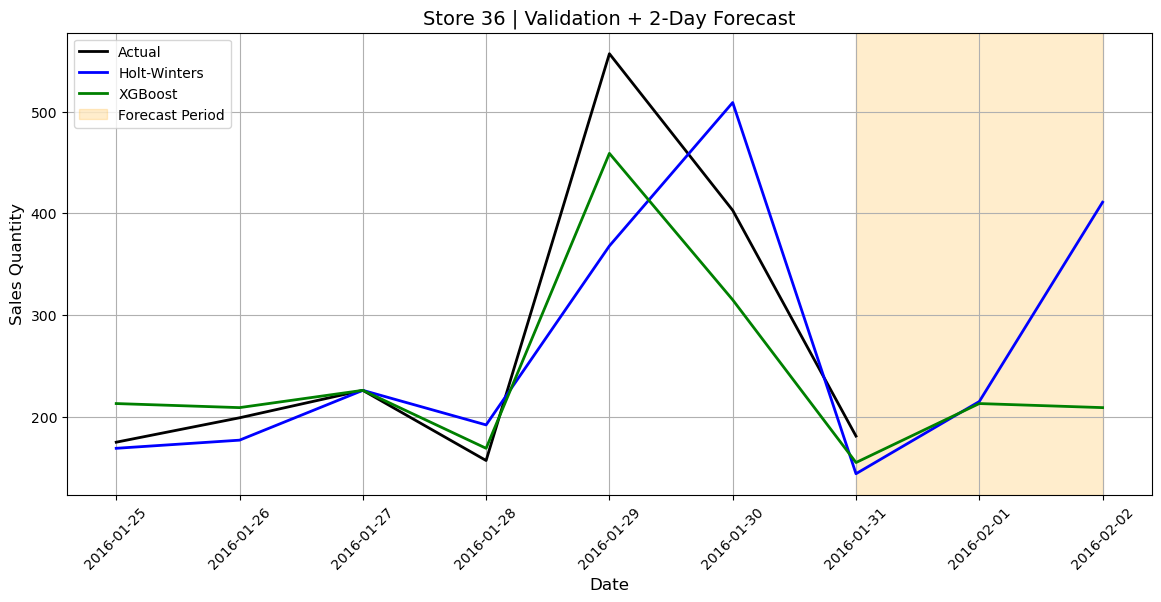

In [9]:
# Combine validation + forecast for Holt-Winters
hw_val_plot_copy = hw_val_plot.rename(columns={'Prediction': 'HW_Prediction'}).copy()
hw_future_plot = hw_forecast_df.rename(columns={'Forecast': 'HW_Prediction'}).copy()
hw_full_plot = pd.concat([hw_val_plot_copy.set_index('SalesDate'), hw_future_plot.set_index('Date')])

# Combine validation + forecast for XGBoost
xgb_val_plot_copy = xgb_val_plot.drop(columns=['Actual']).rename(columns={'Prediction': 'XGB_Prediction'}).copy()
xgb_future_plot = xgb_forecast_df.rename(columns={'Forecast': 'XGB_Prediction'}).copy()
xgb_full_plot = pd.concat([xgb_val_plot_copy.set_index('SalesDate'), xgb_future_plot.set_index('Date')])

# Merge both models
combined = hw_full_plot.join(xgb_full_plot, how='outer')

# Add Actuals for validation period only
combined['Actual'] = hw_val_plot['Actual'].values.tolist() + [np.nan]*FORECAST_DAYS

# Plot
plt.figure(figsize=(14,6))
plt.plot(combined.index, combined['Actual'], label='Actual', color='black', linewidth=2)
plt.plot(combined.index, combined['HW_Prediction'], label='Holt-Winters', color='blue', linewidth=2)
plt.plot(combined.index, combined['XGB_Prediction'], label='XGBoost', color='green', linewidth=2)

# Highlight forecasted period: from day after last validation to last forecast
last_val_date = hw_val_plot['SalesDate'].max()
last_forecast_date = hw_forecast_df['Date'].max()
plt.axvspan(last_val_date,
            last_forecast_date,
            color='orange',
            alpha=0.2,
            label='Forecast Period')

# Labels, title, grid
plt.title(f"Store {selected_store} | Validation + {FORECAST_DAYS}-Day Forecast", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales Quantity", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()